# CM50270 Reinforcement Learning: Coursework 4 (Mountain Car)

Please remember: 
(1) Restart the kernel and run all cells before submitting the notebook. This will guarantee that we will be able to run your code for testing.
(2) Save your work regularly. 

###  Code for Mountain Car 

We provide a `MountainCar` class that you can use. This implementation is based on the problem description given in [Example 8.2](http://www.incompleteideas.net/book/ebook/node89.html) of Sutton & Barto (1998) The following cells in this section will walk you through the basic usage of this class.

We import the mountaincar module and create a `MountainCar` object called `env`. The `reset()` method chooses a random starting `position` and starting `velocity` for the car, and sets the `game_over` variable to `False`. You can access these state variables independently using the same names.

In [1]:
import numpy as np
import mountaincar

np.random.seed(7)

env = mountaincar.MountainCar()
env.reset()
print("Starting position of the car", env.position)
print("Starting velocity of the car", env.velocity)
if not env.game_over:
    print("Game is not over yet.")

Starting position of the car -0.454704306550481
Starting velocity of the car 0.03128512489633177
Game is not over yet.


You can visualize the current position of the car using the `plot()` method.

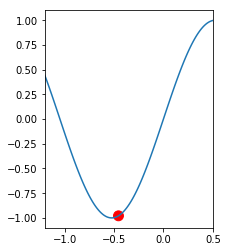

In [2]:
env.plot()

You can interact with the `MountainCar` environment using the `make_step()` method. This method takes an `action` as input and computes the response of the environment. This method returns a `reward` signal, which is always -1.

The action can be one of the following integers:
* -1: full throttle reverse
*  0: zero throttle
*  1: full throttle forward

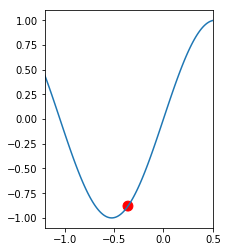

In [3]:
# Let's drive a bit full throttle forward and plot again.
env.make_step(action=1)
env.make_step(action=1)
env.make_step(action=1)
env.plot()

The following code snippet shows that even at full throttle the car cannot accelerate up the steep slope.

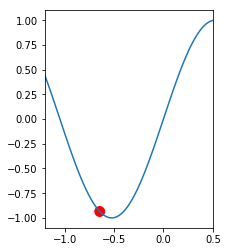

In [4]:
num_steps = 150
for episode in range(num_steps):
    # Always action 1 (full throttle forward)
    env.make_step(action=1)
    env.plot()

## Part 1 (50 marks):

For your reference, the pseudo-code for  _Linear, gradient-descent Sarsa($\lambda$)_ is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, [Section 8.4](http://www.incompleteideas.net/book/ebook/node89.html#fig:FAsarsa).
<img src="images/gradient_descent_Sarsa.png" style="width: 500px;"/>

Please plot an average learning curve for your agent. This should be a static figure of _precomputed_ results, clearly showing (1) how efficiently an average agent learns, and (2) how good the eventual policy is. In five sentences or less, describe your choice of parameter settings and your results.

In addition, please write code to produce a learning curve for a _single_ agent. This shoud be a dynamic figure that we can produce from scratch by executing your code. This figure can show less detail than the static plot. 


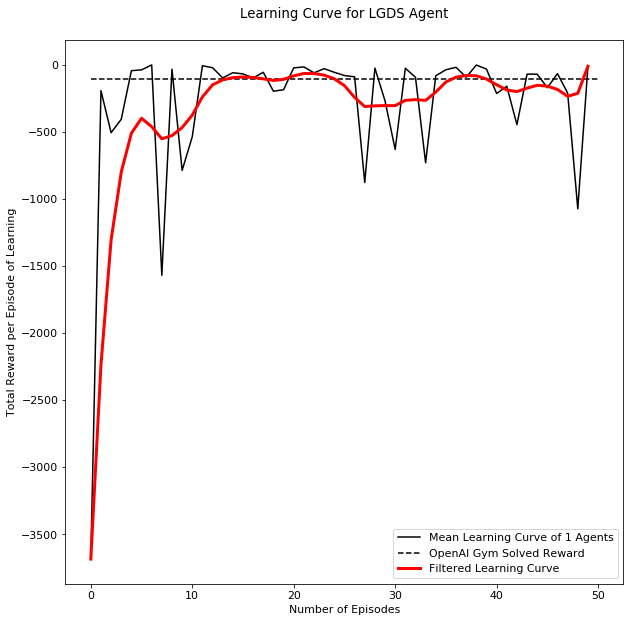

In [5]:
############################################################ RL CWK4 ############################################################

"""
Properties of environment
- If it hits the left hand wall, velocity is set to zero.
- If it hits the right wall, game is won.
- The velocity and postions are clipped by the max velocity and max positions such that the car can never exceed theese.
- Velocity and position are numerically calculated from the acceleration by integration.
- If game is won then self.game_over becomes True
- Resets can be made to middle and zero velocity by setting self.fixed_starts to True - this is for testing the agent.
- self.position is S
- self.velocity is V
- Max s is  0.5, min s is  -1.2, range s is  1.7 .
- Max v is 0.07, min v is -0.07, range v is 0.14 .

Uusing tilings of 9x9 and allowing for a column and row overlap such that the space can be gridded exactly by an 8x8 tiling.
- Axis s tile is 0.2125
- Axis v tile is 0.0175
"""

############################################################ Imports ############################################################

import numpy as np
import matplotlib.pyplot as plt
import mountaincar
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
from scipy import signal

############################################################ Classes ############################################################

class Feature():
    """
    This class represents a feature for a reinforcement learning agent.
    """
    def __init__(self, vUp, vLo, sUp, sLo, action):
        """
        The class stores it's own boundaries within, allowing the object to itself determine if the mountain car is within
        the state, the four boundaries are as follows:
        Vup is the upper boundary for the tiles v
        Vlo is the lower boundary for the tiles v
        Sup is the upper boundary for the tiles s
        Slo is the lower boundary for the tiles s
        """
        self.vUp = vUp
        self.vLo = vLo
        self.sUp = sUp
        self.sLo = sLo
        """
        The features also exist for a particular action.
        """
        self.action = action
        self.theta = 0
        self.e = 0
    
    def activated(self, v, s):
        """
        Given a velocity and position, determines whether the car is within the feature and hence activating it.  Note that
        despite the continuous nature of a float, < and >= have been used to correctly define boudaries.
        """
        return (v < self.vUp) and (v >= self.vLo) and (s < self.sUp) and (s >= self.sLo)
    
    def plotFeature(self):
        """
        Plots the cell in matpltlib for diagnostics.
        """
        v = [self.vUp,self.vLo,self.vLo,self.vUp,self.vUp]
        s = [self.sUp,self.sUp,self.sLo,self.sLo,self.sUp]
        plt.plot(v,s,color = 'r')



class LGDSagent():
    """
    This is the linear gradiaent descent SARSA agent object (LGDSagent), containing all relevent methods.  Throughout this
    implemntation s is used for position and v for velocity.
    """
    def __init__(self, epsilon, gamma, alpha, lambd, traces):
        """
        Class constructor.  Firstly creates all of the required features, then creates an internal training environment based
        on mountain car.  Then initialises all of the verious parameters.
        """
        self.features = self.genFeatures()
        # Generates all of the neseccarry features.

        self.trainEnv = mountaincar.MountainCar()
        self.trainEnv.reset()
        # Creates an internal training environment.
        self.testEnv = mountaincar.MountainCar()
        self.testEnv.reset()
        self.testEnv.fixed_starts = True
        # Creates an internal testing environment.  Also sets the testing environment to fixed starts for consistency.

        self.traces = traces
        # Traces is either 'acc' for accumulating or 'rep' for replacing.
        self.epsilon = epsilon
        self.gamma = gamma
        self.alpha = alpha
        self.lambd = lambd
        # Learning parameters, epsilon is the search rate, lambd is lambda, the is the trace decay rate, gamma is the discount
        # factor, and alpha is the learning rate.

    ####################################################### Agent Methods #######################################################

    def genFeatures(self):
        """
        Generates the grid tilings for the space.

        Each grid is three dimensional:
        - 9 in the v axis.
        - 9 in the s axis.
        - 3 in the a axis for the three different actions.  Specifically indexs 0,1,2 are actions -1,0,1 respectively.

        There are then ten of these grids each with a random shuffeling over the v and s axis. To store this I create an array
        of length 810 for each feature in the v and s axis and depth 3 to replecate the features over the v and s axis in the
        a axis.
        """
        features = np.empty((3,810), dtype = object)
        # Pre-initialises an array to contain the features.
        vBounds = np.linspace(-0.07-0.0175, 0.07, 10)
        sBounds = np.linspace( -1.2-0.2125,  0.5, 10)
        # These are the unshifted boundaries of the grids.
        idx = 0
        # Index at which to slot in the feature in the array of features.
        for i in range(10):
            # Iterate over the number of grids.
            vShift = np.random.random()*0.0175
            sShift = np.random.random()*0.2125
            # Applies a random shift to the three grids in this step.
            for j in range(9):
                # Iterate over the v's.
                for k in range(9):
                    # Iterate over the s's.
                    features[0,idx] = Feature(vBounds[j+1]+vShift, vBounds[j]+vShift,sBounds[k+1]+sShift, sBounds[k]+sShift,-1)
                    features[1,idx] = Feature(vBounds[j+1]+vShift, vBounds[j]+vShift,sBounds[k+1]+sShift, sBounds[k]+sShift, 0)
                    features[2,idx] = Feature(vBounds[j+1]+vShift, vBounds[j]+vShift,sBounds[k+1]+sShift, sBounds[k]+sShift, 1)
                    # Creates the three features one for each action.
                    """ ALGORITHM: Initialise theta arbitrarily. """
                    idx += 1
        # Generates all of the features following the tiling method.
        return features

    def setTraces(self, v, s, a):
        """
        Given the current state - v,s - and action - a - iterates through all active features and sets the trace for these
        features.  Furthermore it has the ability to set the trace to accumulating or replacing based on self.traces.  The
        method takes in the actual action - -1,0,1 - and converts these to the indexes - 0,1,2 by adding one.
        """
        aIndex = a+1
        # Shifts the action into the index.
        if self.traces == 'acc':
            # This section is for accumulating traces.
            for i in self.features[aIndex]:
                # Iterates over the set of features.
                if i.activated(v, s):
                    # If the feature is activated.
                    i.e += 1
                    # Acumulates the trace

        if self.traces == 'rep':
            # This section is for replacing traces.
            for i in self.features[aIndex]:
                # Iterates over the set of features.
                if i.activated(v, s):
                    # If the feature is activated.
                    i.e = 1
                    # Replaces the trace

    def zeroTraces(self):
        """
        Sets the all traces to zero over the entire set of features.
        """
        for i in range(np.shape(self.features)[0]):
            # Iterates over actions
            for j in range(np.shape(self.features)[1]):
                # Iterates over features.
                self.features[i,j].e = 0

    def sumThetas(self, v, s, a):
        """
        Sums all of the theta for activated features given the state - v,s - and the action - a.  The method takes in the actual
        action - -1,0,1 - and converts these to the indexes - 0,1,2 by adding one.
        """
        sigmaTheta = 0
        # The sum of the thetas.
        aIndex = a+1
        # Shifts the action into the index.
        for i in self.features[aIndex]:
            # Iterates over the set of features.
            if i.activated(v, s):
                # If the feature is activated.
                sigmaTheta += i.theta
                """ ALGORITHM: sum of thetas from Fa """
                # Adds the features theta to the running sum.
        return sigmaTheta

    def epsilonGreedy(self, v, s, epsilon):
        """
        Chooses the best action given the state and using the features.
        """
        if np.random.random() > epsilon:
            # Chooses the desired action with 1-epsilon probability.
            qRev = self.sumThetas(v,s,-1)
            qStl = self.sumThetas(v,s,0)
            qFwd = self.sumThetas(v,s,1)
            # These are the availible Q's.
            """ ALGORITHM: For all a belonging to A(s):               """
            """ ALGORITHM:     Fa <- set of features present in s, a  """
            """ ALGORITHM:     Qa <- Sum of thetas for features in Fa """
            qAvailible = [qRev,qStl,qFwd]
            # Creates a list of the availible Q's.
            indexMax = np.argmax(qAvailible)
            # Calculates the index of the maximum Q value from the list.
            # ALGORITHM: a <- argmaxa(Qa)
            return indexMax-1, qAvailible[indexMax]
            # Returns both the best action and it's asociated Q value, note that the action is simply the index -1.
        else:
            # Chooses random action with epsilon probability.
            action = np.random.randint(-1,2)
            # Chooses a random action from -1,0,1
            """ ALGORITHM: a <- a random action belonging to A """
            return action, self.sumThetas(v,s,action)
            # Returns both the random action and the Q for that random action.

    def updateEpisode(self):
        """
        Performs the algorithm for linear gradient descent SARSA.  Note that the state is both v the velocity and s the position.
        """
        
        cumulativeReward = 0
        
        """ AGLORITHM: (for each episode): """
        # This function only performs a single update episode.

        self.zeroTraces()
        # Sets all traces to zero again.
        """ ALGORITHM: e vector = 0 vector """

        self.trainEnv.reset()
        # Resets the environment.
        s = self.trainEnv.position
        v = self.trainEnv.velocity
        a, q = self.epsilonGreedy(v, s, self.epsilon)
        # Initial state and actions, I set the initial action epsilon greedily.
        """ ALGORITHM: s,a <- initial state and action of episode. """

        while True:
            # Repeats steps until the state is terminal by looping for ever until function is returned.
            """ ALGORITHM: Repeat(for each step of episode) """

            self.setTraces(v, s, a)
            # Sets all of the traces at the start of each step.
            """ ALGORITHM: For all i ∈ to Fa:                       """
            """ ALGORITHM:     e(i) <- e(i)+1 (accumulating traces) """
            """ ALGORITHM:     or e(i) <- 1   (replacing traces)    """

            r = self.trainEnv.make_step(a)
            # Takes the action in the environment and observes r.
            sNxt = self.trainEnv.position
            vNxt = self.trainEnv.velocity
            # Observes the state after the action has been taken.
            """ ALGORITHM: Take action a, observer reward, r, and next state, s. """

            delta = r - self.sumThetas(v, s, a)
            # This sets delta based on the thetas from the features present in the current step.
            """ ALGORITHM: δ <- Σ(i ∈ to Fa)theta(i) """

            s = sNxt
            v = vNxt
            # After performing the delta update s and v can be updated.
            a, q = self.epsilonGreedy(v, s, self.epsilon)
            # Calculates epsilon greedily the best action and associated state.
            """ ALGORITHM: With Probability 1-ϵ:                        """
            """ ALGORITHM:     For all a ∈ A(s):                        """
            """ ALGORITHM:         Fa <- set of features present in s,a """
            """ ALGORITHM:         Qa <- Σ(i ∈ to Fa)theta(i)           """
            """ ALGORITHM:     a <- argmaxa(Qa)                         """
            """ ALGORITHM: else:                                        """
            """ ALGORITHM:     a <- a random action ∈ A(s)              """
            """ ALGORITHM:     Fa <- set of features present in s,a     """
            """ ALGORITHM:     Qa <- Σ(i ∈ to Fa)theta(i)               """

            delta = delta + self.gamma * q
            # Updates delta.
            """ ALGORITHM: δ <- δ + γQa """

            for i in range(3):
                # Iterates over all of the actions.
                for j in self.features[i]:
                    # Iterates over all of the features in each action.
                    j.theta = j.theta + (self.alpha*delta*j.e)
                    # Updates the theta values.
                    """ ALGORITHM: θ <- θ + αδe """
            """ ALGORITHM: θ vector <- θ vector + αδe vector """

            for i in range(3):
                # Iterates over all of the actions.
                for j in self.features[i]:
                    # Iterates over all of the features in each action.
                    j.e = self.gamma * self.lambd * j.e
                    # Updates the traces so that they all decrease over time.
                    """ ALGORITHM: e <- γλe """
            """ ALGORITHM: e vector <- γλe vector """
            
            cumulativeReward += r

            if self.trainEnv.game_over:
                return cumulativeReward
            # If the state is terminal then the episode ends - essentially the car has reached the top.
            """ ALGORITHM: until s is terminal """

    ################################################# Training&Testing Methods ##################################################

    def train(self, numberEpisodes):
        """
        Trains the agent and returns the learning curve, tests occur after testInterval number of episodes has happend.  A test
        averages the reward of testGames number of games.
        """
        learningCurve = []
        # The array into which the rewards are inserted.
        for i in range(numberEpisodes):
            episodeReward = self.updateEpisode()
            # Performs an update.
            learningCurve.append(episodeReward)
        return learningCurve

    ##################################################### Plotting Methods ######################################################

    def plotFunction(self):
        """
        Plots the cost function over both v and s, this is to replecate the books to verify results.
        """
        vRange = np.linspace(-0.07, 0.07, 40)
        sRange = np.linspace( -1.2,  0.5, 40)
        grid = np.zeros((40,40))
        for i in range(40):
            for j in range(40):
                grid[i,j] = -self.epsilonGreedy(vRange[i], sRange[j], 0)[1]
        y = vRange
        x = sRange
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        x, y = np.meshgrid(x, y)
        ax.plot_wireframe(x, y, grid)
        ax.set_xlabel("Position")
        ax.set_ylabel("Velocity")
        ax.set_zlabel("-max(cost)")

    def plotAction(self):
        """
        Plots the best action avalible over over both v and s.
        """
        vRange = np.linspace(-0.07, 0.07, 40)
        sRange = np.linspace( -1.2,  0.5, 40)
        grid = np.zeros((40,40))
        for i in range(40):
            for j in range(40):
                grid[i,j] = self.epsilonGreedy(vRange[i], sRange[j], 0)[0]
        y = vRange
        x = sRange
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        x, y = np.meshgrid(x, y)
        ax.plot_wireframe(x, y, grid)
        ax.set_xlabel("Position")
        ax.set_ylabel("Velocity")
        ax.set_zlabel("Best Action")

    def plotFeatures(self):
        """
        Plots the features over both v and s for diagnostics.
        """
        for i in self.features[0]:
            if i != None:
                i.plotFeature()
        plt.plot([-0.07,0.07,0.07,-0.07,-0.07],[-1.2,-1.2,0.5,0.5,-1.2], color = 'b')

    def plotActive(self, v, s, a):
        """
        Plots all active features given a state and action.
        """
        for i in self.features[a+1]:
            if i.activated(v, s):
                i.plotFeature()
        plt.plot([-0.07,0.07,0.07,-0.07,-0.07],[-1.2,-1.2,0.5,0.5,-1.2], color = 'b')

############################################################ Methods ############################################################

def trainMultiple(numberAgents, nuberEpisodes, hyperparams, printAgent = False, agentType = 'grid'):
    """
    This trains multiple agents and outputs an averaged learning curve for all of them.  The method calls for a list of the
    training hyper parameters.
    """
    learningCurve = np.zeros((numberAgents,numberEpisodes), dtype = float)
    # This is the array into which individula learning curves are placed.
    for i in range(numberAgents):
        if agentType == 'grid':
            agent = LGDSagent(hyperparams[0], hyperparams[1], hyperparams[2], hyperparams[3], hyperparams[4])
        if agentType == 'polar':
            agent = PolarLGDSagent(hyperparams[0], hyperparams[1], hyperparams[2], hyperparams[3], hyperparams[4])
        # Initialises agent on the fly.
        learningCurve[i] = np.array(agent.train(numberEpisodes))
        # Trains the agent and adds this to the list of learning curves.
        if printAgent:
            print('Agent number '+str(i)+' training complete.')
    learningCurve = np.average(learningCurve, axis=0)
    # Flattens the learning curve by calculating the mean reward at each episode.
    return learningCurve

def plotLearning(rewards, numberAgents, agent = 'LGDS'):
    """
    Takes a learning curve and plots it in a nice and pretty graph.
    """
    winLinex = [0,np.shape(rewards)[0]]
    winLiney = [-110,-110,]
    b, a = signal.butter(1, 0.2)
    matplotlib.rcParams.update({'font.size': 11})
    rewardssmoothed = signal.filtfilt(b, a, rewards, padlen=15)
    fig, ax = plt.subplots(figsize=(10, 10))
    line1, = ax.plot(rewards, label="Mean Learning Curve of "+str(numberAgents)+" Agents",linestyle = '-', color = 'k')
    line2, = ax.plot(winLinex, winLiney, label="OpenAI Gym Solved Reward",linestyle = '--', color = 'k')
    line3, = ax.plot(rewardssmoothed, label='Filtered Learning Curve',linestyle = '-', color = 'r', linewidth = 3)
    ax.set_xlabel('Number of Episodes')
    ax.set_ylabel("Total Reward per Episode of Learning")
    if agent == 'LGDS':
        ax.set_title("Learning Curve for LGDS Agent\n")
    if agent == 'Polar':
        ax.set_title("Learning Curve for Polar LGDS Agent\n")
    ax.legend()

######################################################### Demonstrating #########################################################

np.random.seed(42)
# Seeding for consistency

epsilon = 0.2
gamma = 1.0
alpha = 0.14
lambd = 0.9
traces = 'rep'
# 'rep' for replacing and 'acc' for accumulating.
hyperparameters = [epsilon, gamma, alpha, lambd, traces]
# Initialises hyperparameters.

numberEpisodes = 50
numberAgents = 50
# Training & testing parameters.

numberAgents = 1
""" THIS SETS TO A SINGLE AGENT FOR MARKING """

learningCurve = trainMultiple(numberAgents, numberEpisodes, hyperparameters, printAgent = False)
# Trains multiple agents.
plotLearning(learningCurve, numberAgents)
# Plots the learning Curve

#################################################################################################################################

Please make sure that all of your code is above this cell. Here, please insert your static learning curve and answer the verbal questions (describe your choice of parameters and results). 

<img src="GridAgent.png" style="width: 600px;"/>

Richard S. Sutton and Andrew G. Barto show that an alpha of 0.14, a lambda of 0.9, and repling traces prvides the best initial learning performance; this is likely to lead to greater effeciency in learning, as convergence happens sooner.  I found much like Richard, S. Sutton and Andrew G. Barto, that these values lead to excelent performance.  Furthermore I use an epsilon of zero, as the environment already has exploring starts built in, leading to a good exploration of states, a non zero epsilon leads to much exploration, slowing convergence.  In addition I use a gamma of one, as the agent does not learn below a lambda of one.  The learning curve shows rapid convergence only taking aproximately 10 episodes, it also learns a good policy with an average reward above -110, which is what the openAI gym specify as having solved the problem (https://github.com/openai/gym/wiki/Leaderboard#mountaincar-v0).


## Part 2 (50 marks)


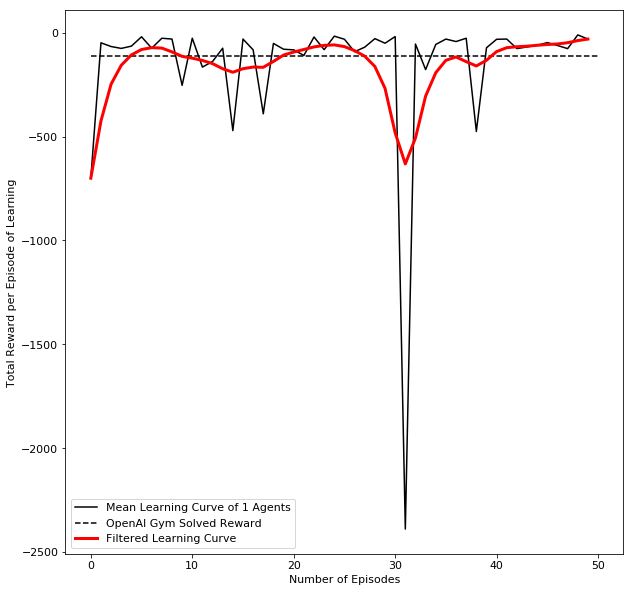

In [6]:
############################################################ Imports ############################################################

import math

############################################################ Classes ############################################################

class PolarFeature():
    """
    This class is a modification of the feature class that provides largely the same methods but instead allows for the creation
    of a polar feature grid, as opposed to a rectangular grid.  Note that as with most polar coordinate systems, anticlokwise is
    positive.
    """
    def __init__(self, rMax, rMin, thetaMax, thetaMin, scale, action):
        """
        Class constructor.  The feature is donut-wedge shaped, and can be shifted and scaled in the s and v axis.
        """
        self.rMax = rMax # Outer radius.
        self.rMin = rMin # Inner radius.
        self.thetaMax = thetaMax # Second edge ccw.
        self.thetaMin = thetaMin # First edge ccw.
        self.vScale = scale[0] # Linear scale in the v axis.
        self.vShift = scale[1] # Linear translation in the v axis.
        self.sScale = scale[2] # Linear scale in the s axis.
        self.sShift = scale[3] # Linear translation in the s axis.
        """
        The features also exist for a particular action.
        """
        self.action = action
        self.theta = 0
        self.e = 0

    def toPolar(self, v, s):
        """
        Converts coordinates in v and s to polar coordinates. NOTE s is equivalent to y and v to x.
        """
        v = (v-self.vShift)/self.vScale
        s = (s-self.sShift)/self.sScale
        # Scaling and translating the cartesan coordinates appropriately.
        r = (v**2+s**2)**0.5
        theta = np.arctan2(s,v)
        # Transforming to polar coordinates.
        return r, theta

    def toGrid(self, r, theta):
        """
        Converts from polar to v and s coordinates. NOTE s is equivalent to y and v to x.
        """
        v = r*np.cos(theta)
        s = r*np.sin(theta)
        # Transforming from polar coordinates.
        v = (v*self.vScale)+self.vShift
        s = (s*self.sScale)+self.sShift
        # Undoing the scaling and translating.
        return v, s

    def plotFeature(self):
        """
        Plots the feature.
        """
        theta = np.append(np.linspace(self.thetaMin,self.thetaMax,12),np.linspace(self.thetaMax,self.thetaMin,12))
        r = np.append(np.zeros(12)+self.rMin,np.zeros(12)+self.rMax)
        # Creates the wedge in polar coordinates
        v, s = self.toGrid(r, theta)
        # Transforms the wedge to cartesian v,s coordinates
        plt.plot(v,s, color = 'r')
        # Plots the wedge
    
    def activated(self, v, s):
        """
        Given the velocity and the position, determines if the feature is active.
        """
        r, theta = self.toPolar(v, s)
        # Converts into polar coordinates.
        return (r < self.rMax) and (r >= self.rMin) and (theta < self.thetaMax) and (theta >= self.thetaMin)



class PolarLGDSagent(LGDSagent):
    """
    This is a version of the LGDSagent that uses polar tile coding instead of grid tile coding.  The logic is that the car
    when swinging moves in elleptical paths throughout the states space, thus polar tile coding fits this better.  Furthermore
    much better resolution is provided where it's needed at the center.
    """
    def genFeatures(self):
        """
        Generates a polar tile coding, there are 9 donuts and 9 segments per donut.
        """
        features = np.empty((3,240), dtype = object)
        # Constant scaling vctor.  Note the circle is centered around s = -0.5.
        theta = np.linspace(-math.pi,math.pi+1e-10,9)
        # Creates thetas over one revolution, note that sin and cos are defined from -180 to 180.  The addition of 1e-10 is to
        # correct a numerical presicion error that meant an s of exactly -0.5 was not detected.
        r = np.linspace(0,1.6,7)
        # Creates rs between 0 and just 1.55, this ensures that the whole state space is covered.
        index = 0
        # This is the index at which each feature is inserted.
        for k in range(5):
            vShift = (np.random.random()-0.5)*0.035
            sShift = (np.random.random()-0.5)*0.425
            scale = [0.07,0+vShift,0.85,-0.5+sShift]
            for i in range(8):
                for j in range(6):
                    features[0,index] = PolarFeature(r[j+1], r[j], theta[i+1], theta[i], scale, -1)
                    features[1,index] = PolarFeature(r[j+1], r[j], theta[i+1], theta[i], scale,  0)
                    features[2,index] = PolarFeature(r[j+1], r[j], theta[i+1], theta[i], scale,  1)
                    index += 1
        return features

######################################################### Demonstrating #########################################################

np.random.seed(42)
# Seeding for consistency

epsilon = 0.1
gamma = 1.0
alpha = 0.1
lambd = 0.99
traces = 'rep'
# 'rep' for replacing and 'acc' for accumulating.
hyperparameters = [epsilon, gamma, alpha, lambd, traces]
# Initialises hyperparameters.

numberEpisodes = 50
numberAgents = 50
# Training & testing parameters.

numberAgents = 1
""" THIS SETS TO A SINGLE AGENT FOR MARKING """

learningCurve = trainMultiple(numberAgents, numberEpisodes, hyperparameters, printAgent = False, agentType = 'polar')
# Trains multiple agents.
plotLearning(learningCurve, numberAgents, 'polar')
# Plots the learning Curve

#################################################################################################################################

Please make sure that all of your code is above this cell. Please insert a static learning curve, showing the performance of your learning over time, and answer the questions provided on the coursework specification. Instead of providing your answer here, in this Jupyter notebook, you have the option to provide your answers on a separate pdf document, not exceeding two pages in length. If you do so, please write "Answer in pdf file." in this cell.  

YOUR ANSWER HERE

It is my opinion that the grid tile coding used is inappropriate for this problem.  If an unpowered car, one in which the action is always zero, is left to roll up and down the hill from a given height, it will chart a counterclockwise elipse around the state space of velocity, v and position s.  The elliptical nature of the motion through the state space suggests that a grid might be inappropriate for tile coding as they do not geometrically reflect each other.  However this is not enough of an explantion.

<img src="ElipticalRoutes.png" style="width: 600px;"/>

When trying to escape a reasonable and intuative policy is to drive in reverse when going in reverse and drive forward when going forward, this leads to a spiraling out from the middle of the state space.  This policy requires flipping the direction of action when the velocity is zero.  An agent may learn a simmilar policy, at the very least the agent ought to change direction throughout the cycle of rolling back and forth.  Consequently no matter the radius of the agent in the state space, from a position of -0.5 and velocity of zero, it will need to oscillate it's action from fowards to zero to reverse.

Consequently the same resolution in features should occur regardless of the radius from a state of zero velocity and -0.5 position, such that an agent can still oscilate it's action.  The grid state space does not do this; Grid tile coding of 9x9, as in S. Sutton and Andrew G. Barto's book, in the middle has the same resolution in features vertically and horizontally as at the edges.  To solve this there needs to be greater resolution in the middle, this is why the grid tile coding is inapropriate for the problem.

To solve this I have used polar grid tile coding.  Each feature becomes a wedge of a circle or donut, this means that for any given radius from the zero state, the resolution in tiles is the same.  Beacuse of this I need fewer features to cover the state space, I use 240 instead of 810, as I only use 5 shifted grids as opposed to ten, because I have the resolution where it's needed.  Furthermore I have been careful to use 8 wedges per donut, this means that feature boudaries are aligned with where the action is expected to change, namely around 0 velocity.

<img src="GridTileCoding.png" style="width: 600px;"/>

<img src="PolarTileCoding.png" style="width: 600px;"/>

However beacuse I have changed the tile coding the, required hyperparameters are likely to have changed from the grid tile coding.  Previously I used the optimal hyperparameters from S Sutton and Andrew G. Barto's book, this time it was difficult to  guess approriate hyperparameters given the four variables that I needed to optimise.  Consequently I performed an exaustive search over the space of epsilon, alpha, lambda and the two types of traces.  To imporve the search speed I chose 4 values for each parameter areound what I aticipated was likely to be appropriate.

epsilon = 0.0,   0.1,  0.2,  0.5

alpha   = 0.001, 0.01, 0.05, 0.1 

lambda  = 0.0,   0.5,  0.9,  0.99

traces  = 'accuulating', 'replacing'

This required a total of 128 different learning curves to be produced.  From this I determined that the best values were epsilon = 0.1, gamma = 1.0, alpha = 0.1, lambda = 0.99, traces = 'replacing'.  The learning curve is as follows:

<img src="PolarAgent.png" style="width: 600px;"/>

The polar tiling agent learns very effectively, learning an good policy within one turn, exceeding the perfomance of the grid tiling agent, despite 570 fewer tiles, adding to the computational effeciency too.  Furthermore it learns a better policy which is consistently above the open AI -110 mark, unlike the grid agent which has lots of variation.  From this I conclude that the polar tile coding is a more effective method than the grid tile coding.  Note that unlike the graph fo the Grid Agent, I have cut it off after 30 episodes.